In [1]:
import numpy as np
from scipy.sparse import csc_matrix
import timeit
import concurrent.futures
import matplotlib.pyplot as plt

In [2]:
def random_projections(data_matrix, num_permutations):
    np.random.seed(172)
    random_perm_matrix = np.random.choice([-1, 1], size=(num_permutations, data_matrix.shape[0]))
    signature_matrix = np.zeros((random_perm_matrix.shape[0], data_matrix.shape[1]))

    for c in range(data_matrix.shape[1]):
        x_T = data_matrix[:, c].T
        for r in range(num_permutations): 
            dot_product = x_T.dot(random_perm_matrix[r, :])

            if dot_product > 0:
                signature_matrix[r, c] = 1
            else:
                signature_matrix[r, c] = -1

    return signature_matrix

In [3]:
def discrete_cosine_similarity(q1, q2):
    q1[q1 > 0] = 1
    q2[q2 > 0] = 1

    mag_q1 = np.linalg.norm(q1)
    mag_q2 = np.linalg.norm(q2)

    # Check for almost zero vectors
    if mag_q1 < 1e-10 or mag_q2 < 1e-10:
        return 1.0

    dot_product = np.dot(q1, q2)
    dot_product = np.clip(dot_product, -1.0, 1.0)  # Clip values to ensure they are within valid range

    disc_cos_dist = np.arccos(dot_product / (mag_q1 * mag_q2))
    disc_cos_sim = 1 - disc_cos_dist / np.pi

    return disc_cos_sim

In [4]:
def random_hash_functions(num_functions, num_buckets):
    np.random.seed(1702)
    hash_functions = []
    for _ in range(num_functions):
        a = np.random.randint(1, num_buckets)
        b = np.random.randint(0, num_buckets)
        hash_functions.append(lambda x: tuple((a * xi + b) % num_buckets for xi in x))
    return hash_functions

In [5]:
def apply_lsh_band(band_id, signature_matrix, hash_functions, rows_per_band, num_users):
    start_row = band_id * rows_per_band
    end_row = (band_id + 1) * rows_per_band
    sub_matrix = signature_matrix[start_row:end_row, :]

    bucket_list = {}

    for col_id in range(num_users):
        hashed_value = tuple(hf(tuple(sub_matrix[:, col_id])) for hf in hash_functions)
        if hashed_value not in bucket_list:
            bucket_list[hashed_value] = []
        bucket_list[hashed_value].append(col_id)

    return bucket_list

In [6]:
def apply_lsh_parallel(signature_matrix, hash_functions, num_bands, rows_per_band):
    num_users = signature_matrix.shape[1]
    bucket_lists = [{} for _ in range(num_bands)]

    with concurrent.futures.ThreadPoolExecutor() as executor:
        band_results = list(executor.map(
            lambda x: apply_lsh_band(x, signature_matrix, hash_functions, rows_per_band, num_users),
            range(num_bands)
        ))

    for band_id, band_result in enumerate(band_results):
        bucket_lists[band_id] = band_result

    return bucket_lists

In [7]:
def process_column(col_id, sub_matrix, hash_functions):
    return tuple(hf(tuple(sub_matrix[:, col_id])) for hf in hash_functions)

In [8]:
def find_candidate_pairs(bucket_lists, cosine_similarity_threshold):
    candidate_pairs = set()

    for buckets in bucket_lists:
        for bucket_id, user_list in buckets.items():
            if len(user_list) > 1:
                for i in range(len(user_list)):
                    for j in range(i + 1, len(user_list)):
                        user1 = user_list[i]
                        user2 = user_list[j]
                        candidate_pairs.add(tuple(sorted([user1, user2])))

    return candidate_pairs

In [9]:
def write_to_file(file_path, pairs):
    with open(file_path, 'a') as f:  # Use 'a' mode to append to the file
        for pair in pairs:
            f.write(f"{pair[0]}, {pair[1]}\n")

In [10]:
def calculate_discrete_cosine_similarity(pair, sparse_col_matrix):
    u1, u2 = pair
    v1 = (sparse_col_matrix[:, u1].toarray()).flatten()
    v2 = (sparse_col_matrix[:, u2].toarray()).flatten()

    if not np.any(v1) or not np.any(v2):
        print("Warning: Zero magnitude vector encountered for pair", pair)
        return u1, u2, 0  # Set similarity to zero for zero magnitude vectors

    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)

    dot_product = np.dot(v1, v2)
    disc_cos_dist = np.arccos(dot_product / (mag_v1 * mag_v2))
    disc_cos_sim = 1 - disc_cos_dist / np.pi

    return u1, u2, disc_cos_sim

Create signature matrix...
Time to make signature matrix:  1.1856948854166665  minutes
LSH Execution Time:  0.12100610554999988  minutes
Candidate Pairs Execution Time:  0.004413124999999951  minutes
632921
Final Pairs Execution Time:  4.8468671145833335  minutes
Discrete Cosine Similarity: 31 final pairs:
 [(66491, 98688, 0.7391208877361612), (58328, 91947, 0.751160503648811), (90660, 100801, 0.7401085434320913), (14944, 20668, 0.7384828012280948), (35855, 47930, 0.7389061979802631), (13752, 48992, 0.736190697470974), (3584, 50547, 0.7340740468995297), (27170, 78005, 0.7323454495893307), (5353, 19759, 0.7329374026011903), (63054, 101288, 0.7323936800271224), (4650, 70718, 0.7306715456298), (7518, 48671, 0.7343113717889169), (91158, 100549, 0.7479636504742695), (53912, 83313, 0.7321102065247074), (13029, 91947, 0.7439431566611154), (30722, 47930, 0.7408241803082813), (33146, 64421, 0.7306192890440297), (9772, 51237, 0.7431234323179883), (66491, 90660, 0.73241118000713), (66491, 100801,

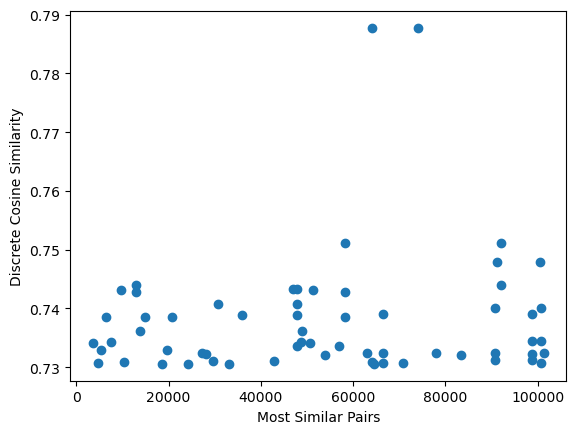

In [11]:
def main():
    # Load the full data
    data = np.load('user_movie_rating.npy')
    
    # Create a sparse column matrix
    sparse_col_matrix = csc_matrix((data[:, 2], (data[:, 1], data[:, 0])))

    # Create a signature matrix
    print("Create signature matrix...")
    begin = timeit.default_timer()
    signature_matrix = random_projections(sparse_col_matrix, num_permutations=80)
    end = timeit.default_timer() - begin
    print('Time to make signature matrix: ', end / 60, ' minutes')

    # Define LSH parameters
    num_hash_functions = 10
    num_buckets = 1000000000000
    num_bands = 1  # Experiment with the number of bands
    rows_per_band = 17  # Experiment with the number of rows per band

    # Generate random hash functions
    hash_functions = random_hash_functions(num_hash_functions, num_buckets)

    # Apply LSH in parallel
    begin = timeit.default_timer()
    bucket_lists = apply_lsh_parallel(signature_matrix, hash_functions, num_bands, rows_per_band)
    end = timeit.default_timer() - begin
    print('LSH Execution Time: ', end / 60, ' minutes')


    # Find candidate pairs
    begin = timeit.default_timer()
    candidate_pairs = find_candidate_pairs(bucket_lists,cosine_similarity_threshold=0.73)
    end = timeit.default_timer() - begin
    print('Candidate Pairs Execution Time: ', end / 60, ' minutes')
    print(len(candidate_pairs))

    # Convert candidate_pairs set to a list
    candidate_pairs = list(candidate_pairs)
    begin = timeit.default_timer()
    # Calculate discrete cosine similarity for candidate pairs
    final_pairs_dcs = []

    def process_batch_dcs(batch):
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(lambda p: calculate_discrete_cosine_similarity(p, sparse_col_matrix), batch))
        return [pair for pair in results if pair[2] > 0.73]

    batch_size = 5000
    for i in range(0, len(candidate_pairs), batch_size):
        batch = candidate_pairs[i:i + batch_size]
        final_pairs_dcs.extend(process_batch_dcs(batch))
    end = timeit.default_timer() - begin
    # Dump results to files
    write_to_file('discrete_cosine_sim_results.txt', final_pairs_dcs)
    print('Final Pairs Execution Time: ', end / 60, ' minutes')
    print("Discrete Cosine Similarity:", len(final_pairs_dcs), "final pairs:\n", final_pairs_dcs)
    
    # Scatter plot for most similar pairs
    most_similar_pairs = sorted(final_pairs_dcs, key=lambda x: x[2], reverse=True)[:50]

    user_pairs = [(pair[0], pair[1]) for pair in most_similar_pairs]
    similarity_scores = [pair[2] for pair in most_similar_pairs]

    flattened_user_pairs = [user for pair in user_pairs for user in pair]
    repeated_similarity_scores = [score for score in similarity_scores for _ in range(2)]

    plt.scatter(flattened_user_pairs, repeated_similarity_scores)
    plt.xlabel('Most Similar Pairs')
    plt.ylabel('Discrete Cosine Similarity')
    plt.show()
    
    return final_pairs_dcs, signature_matrix

final_pairs_dcs, signature_matrix = main()